In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report  # 这个包是评价报告


def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y


def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


def expand_y(y):
    #     """expand 5000*1 into 5000*10
    #     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
    #     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)

    return np.array(res)


# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']


def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))


# 序列化2矩阵
# 在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2
def feed_forward(theta, X):
    """apply to architecture 400+1 * 25+1 *10
    X: 5000 * 401
    """

    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    a1 = X  # 5000 * 401

    z2 = a1 @ t1.T  # 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    return a1, z2, a2, z3, h  # you need all those for backprop


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def deserialize(seq):
    #     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)


def cost(theta, X, y):
    #     """calculate cost
    #     y: (m, k) ndarray
    #     """
    m = X.shape[0]  # get the data size m

    _, _, _, _, h = feed_forward(theta, X)

    # np.multiply is pairwise operation
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    return pair_computation.sum() / m


def regularized_cost(theta, X, y, l=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    reg_t1 = (l / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # this is how you ignore first col
    reg_t2 = (l / (2 * m)) * np.power(t2[:, 1:], 2).sum()

    return cost(theta, X, y) + reg_t1 + reg_t2


def sigmoid_gradient(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))


def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]  # (1, 10)
        yi = y[i, :]  # (1, 10)

        d3i = hi - yi  # (1, 10)

        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)


def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)

    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                             for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print(
        'If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(
            diff))


def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))


def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)

    t1[:, 0] = 0
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)


def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)


def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res


def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))


def plot_hidden_layer(theta):
    """
    theta: (10285, )
    """
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

# nn functions starts here ---------------------------
# ps. all the y here is expanded version (5000,10)


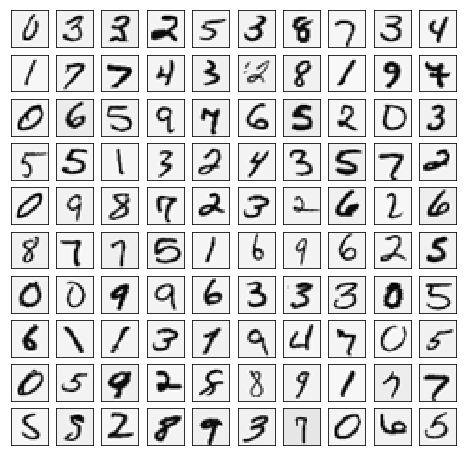

(5000, 401)
[10 10 10 ...  9  9  9]
(25, 401) (10, 26)
(10285,)
[[1.12661530e-04 1.74127856e-03 2.52696959e-03 ... 4.01468105e-04
  6.48072305e-03 9.95734012e-01]
 [4.79026796e-04 2.41495958e-03 3.44755685e-03 ... 2.39107046e-03
  1.97025086e-03 9.95696931e-01]
 [8.85702310e-05 3.24266731e-03 2.55419797e-02 ... 6.22892325e-02
  5.49803551e-03 9.28008397e-01]
 ...
 [5.17641791e-02 3.81715020e-03 2.96297510e-02 ... 2.15667361e-03
  6.49826950e-01 2.42384687e-05]
 [8.30631310e-04 6.22003774e-04 3.14518512e-04 ... 1.19366192e-02
  9.71410499e-01 2.06173648e-04]
 [4.81465717e-05 4.58821829e-04 2.15146201e-05 ... 5.73434571e-03
  6.96288990e-01 8.18576980e-02]]
0.2876291651613189
0.38376985909092365
(5000, 401) (5000, 10)
(25, 401) (10, 26)
(10285,)
0.25
(25, 401) (10, 26)


In [ ]:
# from back_propagation.core import *

X, _ = load_data('ex4data1.mat')
plot_100_image(X)
plt.show()

X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)  # 增加全部为1的一列
print(X.shape)
print(y_raw)

y = expand_y(y_raw)
t1, t2 = load_weight('ex4weights.mat')
print(t1.shape, t2.shape)

theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
print(theta.shape)

_, _, _, _, h = feed_forward(theta, X)
print(h)
# 5000*10
print(cost(theta, X, y))

print(regularized_cost(theta, X, y))

print(X.shape, y.shape)
print(t1.shape, t2.shape)
print(theta.shape)

print(sigmoid_gradient(0))

d1, d2 = deserialize(gradient(theta, X, y))
print(d1.shape, d2.shape)

# gradient_checking(theta, X, y, epsilon=0.0001)
# 这个运行很慢，谨慎运行
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True)
# 这个运行很慢，谨慎运行

res = nn_training(X, y)  # 慢
print(res)

_, y_answer = load_data('ex4data1.mat')
print(y_answer[:20])
final_theta = res.x

plot_hidden_layer(final_theta)
plt.show()